In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


import random
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


2025-07-04 21:00:56.391618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pandas as pd

info = pd.read_csv("studentInfo.csv")
print(info.columns)


Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')


In [6]:
import pandas as pd

info = pd.read_csv("studentInfo.csv")
student_vle = pd.read_csv("studentVLE.csv")
vle = pd.read_csv("vle.csv")


In [7]:
# Joining the VLE logs with week number for each activity
vle_weeks = vle[['id_site', 'week_from']]
student_vle = student_vle.merge(vle_weeks, on='id_site', how='left')


In [8]:
# Joining with final_result to create dropout label
student_vle = student_vle.merge(
    info[['id_student', 'code_module', 'code_presentation', 'final_result']],
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

# Creating binary dropout label 1 = Withdrawn 0 = Not withdrawn
student_vle['dropped_out'] = (student_vle['final_result'] == 'Withdrawn').astype(int)


In [10]:
# Grouping by student and week
weekly_clicks = student_vle.groupby(['id_student', 'week_from']).agg({
    'sum_click': 'sum',
    'dropped_out': 'max'
}).reset_index()

# Renaming for consistency
weekly_clicks.rename(columns={'week_from': 'week', 'sum_click': 'num_clicks'}, inplace=True)


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Defining the full range of weeks (OULAD runs 0–49 weeks)
all_weeks = list(range(0, 50))
all_ids = weekly_clicks['id_student'].unique()

X = []
y = []

for student_id in all_ids:
    student_data = weekly_clicks[weekly_clicks['id_student'] == student_id]
    week_dict = dict(zip(student_data['week'], student_data['num_clicks']))
    label = student_data['dropped_out'].iloc[0]

    # Create a sequence of 50 time steps, fill missing weeks with 0
    sequence = [week_dict.get(w, 0) for w in all_weeks]
    X.append(sequence)
    y.append(label)

# Convert to 3D array for LSTM: (samples, timesteps, features)
X = np.array(X)[:, :, np.newaxis]  # 1 feature: num_clicks
y = np.array(y)


In [13]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example sequence:", X[0].flatten())
print("Label:", y[0])


X shape: (19699, 50, 1)
y shape: (19699,)
Example sequence: [ 0 94 84  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Label: 0


In [19]:
from sklearn.utils import class_weight

# Computing class weights from training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.6416008468365768, 1: 2.265526164462335}


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam

timesteps = X.shape[1]
n_features = X.shape[2]

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, n_features)))  # skip padded 0s
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary dropout prediction

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=64,
          class_weight=class_weights,
          verbose=1)


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6617 - loss: 0.6442 - val_accuracy: 0.6439 - val_loss: 0.6073
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6287 - loss: 0.6160 - val_accuracy: 0.6396 - val_loss: 0.6156
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6342 - loss: 0.6130 - val_accuracy: 0.6444 - val_loss: 0.6173
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6371 - loss: 0.6109 - val_accuracy: 0.6393 - val_loss: 0.6189
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6375 - loss: 0.6090 - val_accuracy: 0.6411 - val_loss: 0.6191
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6390 - loss: 0.6070 - val_accuracy: 0.6523 - val_loss: 0.6107
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6391 - loss: 0.6049 - val_accuracy: 0.6520 - val_loss: 0.6084
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6421 - loss: 0.6043 - val_accu

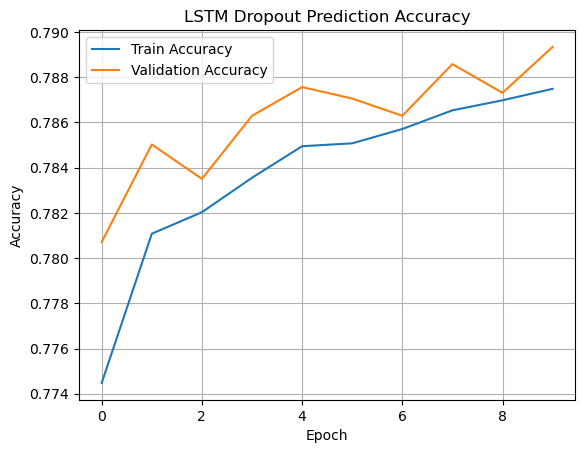

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Dropout Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.metrics import classification_report

# Prediction on validation set
y_pred = (model.predict(X_val) > 0.5).astype(int)

print(classification_report(y_val, y_pred))


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      3067
           1       0.36      0.72      0.48       873

    accuracy                           0.65      3940
   macro avg       0.62      0.67      0.61      3940
weighted avg       0.77      0.65      0.68      3940



In [23]:
model.save("lstm_dropout_model.h5")


In [24]:
from keras.saving import save_model

save_model(model, "lstm_dropout_model.keras")


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 


<Figure size 600x400 with 0 Axes>

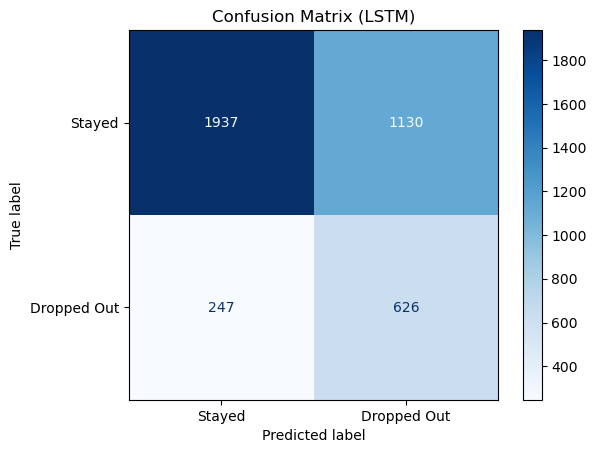

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#prediction
y_pred = (model.predict(X_val) > 0.5).astype(int)

#Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Dropped Out"])

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (LSTM)")
plt.grid(False)
plt.show()


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 


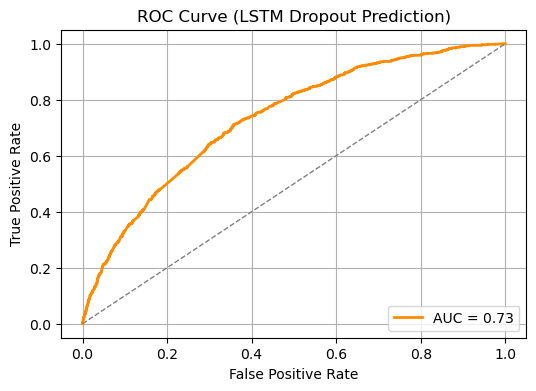

In [26]:
from sklearn.metrics import roc_curve, auc

#Getting predicted probabilities 
y_proba = model.predict(X_val)

#Computing ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

#Plotting ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LSTM Dropout Prediction)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

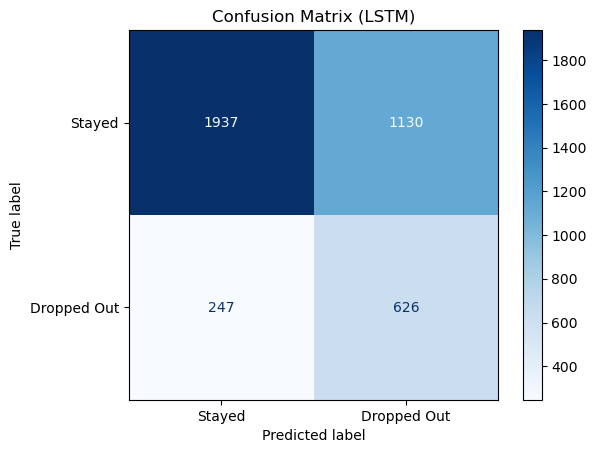

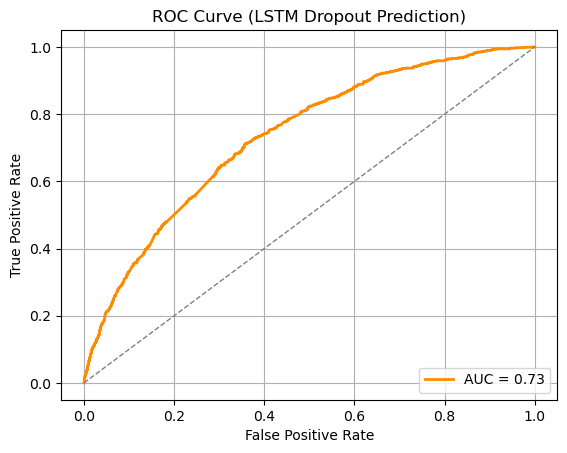

In [27]:
#saving confusion matrix
plt.figure()
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (LSTM)")
plt.savefig("confusion_matrix_lstm.png")

#saving ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LSTM Dropout Prediction)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc_curve_lstm.png")


#adding weekly assesments

In [32]:
#Loading assessment data
sa = pd.read_csv("studentAssessment.csv")
a = pd.read_csv("assessments.csv")

#Merging to get 'date' of assessment
sa = sa.merge(a[['id_assessment', 'date']], on='id_assessment', how='left')

#Dropping rows with missing dates 
sa = sa[sa['date'].notna()]
sa['week'] = (sa['date'] // 7).astype(int)

#Basic columns
sa['attempted'] = 1
sa['score'] = sa['score'].fillna(0)

#Merging the dropout info
sa = sa.merge(
    info[['id_student', 'code_module', 'code_presentation', 'final_result']],
    on='id_student',
    how='left'
)

sa['dropped_out'] = (sa['final_result'] == 'Withdrawn').astype(int)



In [33]:
#Grouping by student and week
weekly_assess = sa.groupby(['id_student', 'week']).agg({
    'attempted': 'sum',
    'score': 'mean',
    'dropped_out': 'max'
}).reset_index()

weekly_assess.rename(columns={
    'attempted': 'num_assessments',
    'score': 'mean_score'
}, inplace=True)


In [34]:

weekly_clicks.rename(columns={'week_from': 'week', 'sum_click': 'num_clicks'}, inplace=True)

#Merging both
weekly_combined = pd.merge(
    weekly_clicks,
    weekly_assess,
    on=['id_student', 'week', 'dropped_out'],
    how='outer'
).fillna(0)


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

all_weeks = list(range(0, 50))  # 0–49 weeks
all_ids = weekly_combined['id_student'].unique()

X = []
y = []

for student_id in all_ids:
    student_data = weekly_combined[weekly_combined['id_student'] == student_id]
    week_map = {
        row['week']: [row['num_clicks'], row['num_assessments'], row['mean_score']]
        for _, row in student_data.iterrows()
    }
    label = student_data['dropped_out'].iloc[0]

    #building sequences for all 50 weeks
    sequence = [week_map.get(w, [0, 0, 0]) for w in all_weeks]
    X.append(sequence)
    y.append(label)

X = np.array(X)  # shape: (n_students, 50, 3)
y = np.array(y)


In [36]:
print("X shape:", X.shape)  
print("y shape:", y.shape)
print("First sequence example (week 0):", X[0][0])  #should print [num_clicks, num_assessments, mean_score]
print("Label:", y[0])


X shape: (24930, 50, 3)
y shape: (24930,)
First sequence example (week 0): [0. 0. 0.]
Label: 0


In [37]:
from sklearn.preprocessing import StandardScaler

#reshaping from (n_students, 50, 3) → (n_students * 50, 3) for scaling
n_students, n_weeks, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)

#scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

#reshaping back to original 3D shape
X = X_scaled.reshape(n_students, n_weeks, n_features)


In [38]:
print("Feature means after scaling:", X.mean(axis=(0, 1)))
print("Feature stds after scaling:", X.std(axis=(0, 1)))


Feature means after scaling: [-1.15855669e-13 -1.64091063e-13 -1.66018948e-14]
Feature stds after scaling: [1. 1. 1.]


lstm training code

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


defining and compiling lstm model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam

timesteps = X.shape[1]       # 50
n_features = X.shape[2]      # 3 (clicks, assessments, mean_score)

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, n_features)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary dropout classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.6448942637263144, 1: 2.2253961169381835}


In [42]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights,
                    verbose=1)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7577 - loss: 0.5322 - val_accuracy: 0.7882 - val_loss: 0.4637
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8044 - loss: 0.3887 - val_accuracy: 0.8063 - val_loss: 0.4236
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8043 - loss: 0.3740 - val_accuracy: 0.8241 - val_loss: 0.3944
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8071 - loss: 0.3690 - val_accuracy: 0.8255 - val_loss: 0.3880
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8084 - loss: 0.3672 - val_accuracy: 0.8267 - val_loss: 0.3844
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8114 - loss: 0.3627 - val_accuracy: 0.8259 - val_loss: 0.3778
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8109 - loss: 0.3589 - val_accuracy: 0.8229 - val_loss: 0.3742
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8136 - loss: 0.3551 - val_acc

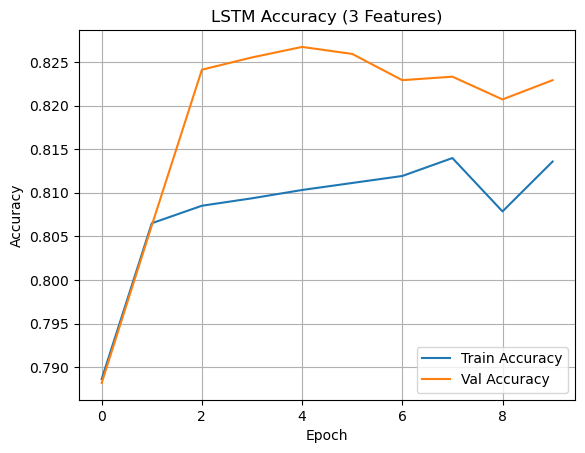

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      3887
           1       0.56      0.91      0.69      1099

    accuracy                           0.82      4986
   macro avg       0.76      0.85      0.78      4986
weighted avg       0.88      0.82      0.84      4986



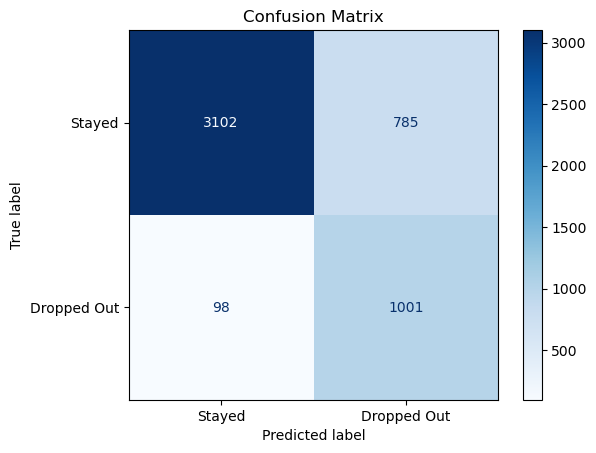

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Accuracy (3 Features)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#predicting and evaluating
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))

#Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Dropped Out"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 


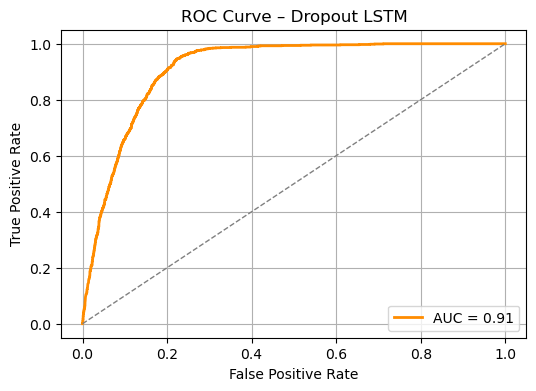

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Predicting probabilities for validation set
y_proba = model.predict(X_val)

#Computing ROC
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Dropout LSTM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [45]:
model.save("lstm_dropout_model_3features.keras")


#diff approach train lstm on first 4 weeks

In [46]:
#slicing first 5 weeks only
X_early = X[:, :5, :]  # shape: (n_students, 5, 3)


In [47]:
from sklearn.model_selection import train_test_split

X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(X_early, y, test_size=0.2, random_state=42)


define early warning lstm

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam

timesteps = X_train_e.shape[1]  # now 5
n_features = X_train_e.shape[2]  # still 3

early_model = Sequential()
early_model.add(Masking(mask_value=0., input_shape=(timesteps, n_features)))
early_model.add(LSTM(64, return_sequences=False))
early_model.add(Dense(32, activation='relu'))
early_model.add(Dense(1, activation='sigmoid'))

early_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

early_model.summary()


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 5, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from sklearn.utils import class_weight

class_weights_early = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_e),
    y=y_train_e
)
class_weights_early = dict(enumerate(class_weights_early))


In [50]:
history_early = early_model.fit(X_train_e, y_train_e,
                                validation_data=(X_val_e, y_val_e),
                                epochs=10,
                                batch_size=64,
                                class_weight=class_weights_early,
                                verbose=1)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6729 - loss: 0.6525 - val_accuracy: 0.6823 - val_loss: 0.6193
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6786 - loss: 0.6193 - val_accuracy: 0.6835 - val_loss: 0.6224
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6832 - loss: 0.6127 - val_accuracy: 0.6781 - val_loss: 0.6352
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6878 - loss: 0.6075 - val_accuracy: 0.6771 - val_loss: 0.6380
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6894 - loss: 0.6025 - val_accuracy: 0.6819 - val_loss: 0.6369
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6924 - loss: 0.5983 - val_accuracy: 0.6825 - val_loss: 0.6381
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6971 - loss: 0.5949 - val_accuracy: 0.6849 - val_loss: 0.6372
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7012 - loss: 0.5923 - val_accuracy: 0.

In [51]:
from sklearn.metrics import classification_report

y_pred_e = (early_model.predict(X_val_e) > 0.5).astype(int)
print(classification_report(y_val_e, y_pred_e))


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step    
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      3887
           1       0.39      0.70      0.50      1099

    accuracy                           0.69      4986
   macro avg       0.64      0.69      0.64      4986
weighted avg       0.78      0.69      0.71      4986



In [52]:
early_model.save("lstm_dropout_early5w.keras")


#multitask lstm

In [53]:
#Creating binary final result label
info['final_pass'] = info['final_result'].apply(
    lambda x: 1 if x in ['Pass', 'Distinction'] else 0
)


In [54]:
#Extracting final_pass for each student in same order as X/y
student_ids = weekly_combined['id_student'].unique()

#Matching the final_pass label for each id
final_result_map = info.set_index('id_student')['final_pass'].to_dict()
y_final = np.array([final_result_map.get(sid, 0) for sid in student_ids])


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_dropout, y_val_dropout, y_train_final, y_val_final = train_test_split(
    X, y, y_final, test_size=0.2, random_state=42
)


In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.optimizers import Adam

timesteps = X.shape[1]
n_features = X.shape[2]

input_layer = Input(shape=(timesteps, n_features))
x = Masking(mask_value=0.)(input_layer)
x = LSTM(64)(x)

#Multi-task output heads
dropout_output = Dense(1, activation='sigmoid', name='dropout')(x)
final_output = Dense(1, activation='sigmoid', name='final_result')(x)

#creating model
model = Model(inputs=input_layer, outputs=[dropout_output, final_output])

model.compile(optimizer=Adam(0.001),
              loss={
                  'dropout': 'binary_crossentropy',
                  'final_result': 'binary_crossentropy'
              },
              metrics={
                  'dropout': 'accuracy',
                  'final_result': 'accuracy'
              })

model.summary()



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 50, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 50, 3)     │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 50, 3)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_14 (Any)        │ (None, 50)        │          0 │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     17,408 │ masking_5[0][0],  │
│                     │                   │            │ any_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dense)     │ (None, 1)         │         65 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_result        │ (None, 1)         │         65 │ lstm_5[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,538 (68.51 KB)

 Trainable params: 17,538 (68.51 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:

history = model.fit(
    X_train,
    {'dropout': y_train_dropout, 'final_result': y_train_final},
    validation_data=(X_val, {'dropout': y_val_dropout, 'final_result': y_val_final}),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - dropout_accuracy: 0.7853 - dropout_loss: 0.4551 - final_result_accuracy: 0.7830 - final_result_loss: 0.4352 - loss: 0.8903 - val_dropout_accuracy: 0.8235 - val_dropout_loss: 0.3503 - val_final_result_accuracy: 0.8933 - val_final_result_loss: 0.2650 - val_loss: 0.6155
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - dropout_accuracy: 0.8226 - dropout_loss: 0.3423 - final_result_accuracy: 0.8941 - final_result_loss: 0.2695 - loss: 0.6118 - val_dropout_accuracy: 0.8257 - val_dropout_loss: 0.3267 - val_final_result_accuracy: 0.9041 - val_final_result_loss: 0.2507 - val_loss: 0.5775
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - dropout_accuracy: 0.8325 - dropout_loss: 0.3188 - final_result_accuracy: 0.8976 - final_result_loss: 0.2628 - loss: 0.5816 - val_dropout_accuracy: 0.8291 - val_dropout_loss: 0.3212 - val_final_result_accuracy: 0.9057 - val_final_result_loss: 0.2477 - val_loss: 0.5690
Epoch 4/10
312/312 ━━━━━━━━━━━

In [61]:
from sklearn.metrics import classification_report

#Getting predictions
dropout_pred_prob, final_pred_prob = model.predict(X_val)

#Converting to binary predictions
dropout_pred = (dropout_pred_prob > 0.5).astype(int)
final_pred = (final_pred_prob > 0.5).astype(int)

#Dropout task performance
print("🔍 Dropout Prediction Report")
print(classification_report(y_val_dropout, dropout_pred))

#Final result task performance
print("📘 Final Result Prediction Report")
print(classification_report(y_val_final, final_pred))


156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 
🔍 Dropout Prediction Report
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3887
           1       0.59      0.79      0.68      1099

    accuracy                           0.83      4986
   macro avg       0.76      0.82      0.78      4986
weighted avg       0.86      0.83      0.84      4986

📘 Final Result Prediction Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      2090
           1       0.90      0.96      0.93      2896

    accuracy                           0.91      4986
   macro avg       0.92      0.90      0.91      4986
weighted avg       0.91      0.91      0.91      4986



In [62]:
model.save("lstm_multitask_dropout_finalresult.keras")


#Use LSTM embedding in deepsurv

In [63]:
pip install pycox torchtuples


  Preparing metadata (setup.py) ... one
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.9 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2493 sha256=b5bd1d4d4430b6021cfbb5980ced32be789f7b6a28a248636230644f2fedcc33
  Stored in directory: /Users/sahaana/Library/Caches/pip/wheels/dd/02/6b/2f0f7e1c0454094c880e63076da142e67f1ba72f82baa6195f
Successfully built feather-format
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
Note: you may need to restart the kernel to use updated packages.


#time to even labels

In [64]:
# student_vle should contain: id_student, week_from
duration_df = student_vle.groupby('id_student')['week_from'].max().reset_index()
duration_df.rename(columns={'week_from': 'duration'}, inplace=True)

# Using final labels from info
event_df = info[['id_student', 'final_result']].copy()
event_df['event'] = (event_df['final_result'] == 'Withdrawn').astype(int)

# Merging into a single survival label frame
survival_labels = duration_df.merge(event_df[['id_student', 'event']], on='id_student', how='left')


#extract lstm embedddings

In [67]:
# Show layer index, name, and type (safe from AttributeError)
for i, layer in enumerate(model.layers):
    try:
        print(f"{i}: {layer.name} — {layer.output_shape}")
    except AttributeError:
        print(f"{i}: {layer.name} — shape not available (type: {type(layer)})")



0: input_layer_5 — shape not available (type: <class 'keras.src.layers.core.input_layer.InputLayer'>)
1: masking_5 — shape not available (type: <class 'keras.src.layers.core.masking.Masking'>)
2: lstm_5 — shape not available (type: <class 'keras.src.layers.rnn.lstm.LSTM'>)
3: dropout — shape not available (type: <class 'keras.src.layers.core.dense.Dense'>)
4: final_result — shape not available (type: <class 'keras.src.layers.core.dense.Dense'>)


In [68]:
from tensorflow.keras.models import Model

# Using the LSTM layer's output as the embedding
embedding_model = Model(inputs=model.input, outputs=model.layers[2].output)

# Generating embeddings
X_embed = embedding_model.predict(X, batch_size=512)
print("LSTM embedding shape:", X_embed.shape)  # Expected: (24930, 64)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
LSTM embedding shape: (24930, 64)
